In [93]:
# Dependencies
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import colors as mcolors
import seaborn as sns
from scipy.stats import linregress
import gmaps
from config import gkey

In [2]:
# Import Duke Energy CSV file
file = "Data/duke_energy_2010.csv"
energy_df = pd.read_csv(file)

In [3]:
# Clean zip code column to be consistently formatted to five digits, format as type string
energy_df["Zip"]=energy_df["SAMPLE_PREMISE_ZIP"].astype(str)
energy_df.Zip = energy_df.Zip.str[:5]

In [4]:
# Import CSV file created from US Census Bureau data that ties each zip code in the US to the latitude and longitude 
# for the geographic centroid of the zip code. CSV file is semi-colon delimited. 
file2 = "Data/us-zip-code-latitude-and-longitude.csv"
latlong_df = pd.read_csv(file2,delimiter=';')

In [5]:
# Format zip code as type string
latlong_df["Zip"]=latlong_df["Zip"].astype(str)

In [6]:
# Find the by zip code average energy usage
byzip = energy_df.groupby("Zip")
byzip_average = byzip["SAMPLE_USAGE"].mean()

In [7]:
# Merge the by zip code avearge energy usage data to the latitude and longitude data on Zip
# Only keep records that are contained in both data frames - inner join
# Nonsensical zip codes are dropped, for instance 0 was listed as a zip code in the duke energy data frame
merged_df = pd.merge(byzip_average, latlong_df, how='inner', on='Zip')

## Figure 1 - Heat Map

In [8]:
# Configure gmaps with API key
gmaps.configure(api_key=gkey)

In [9]:
# Store latitude and longitude in locations
locations = merged_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
usage = merged_df["SAMPLE_USAGE"].astype(float)

In [10]:
# Create heat map layer
fig = gmaps.figure()

heat_layer = gmaps.heatmap_layer(locations, weights=usage, dissipating=False, max_intensity=20000, point_radius=.25)

# Adjust heat_layer setting to help with heatmap dissipating on zoom
heat_layer.dissipating = False
heat_layer.max_intensity = 20000
heat_layer.point_radius = .25

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

## Figure 2 - Household Features

In [11]:
# Household square footage data

# Get rid of missing repsonses - coded as 99 - and I don't know responses - coded as 9 -
energy_sqft = energy_df.loc[(energy_df["Q7"]!=99)]
energy_sqft = energy_sqft.loc[(energy_sqft["Q7"]!=9)]

# Replace 10 with 3 because sequentially <600 sq ft comes before 600-1000 not after 3000+
energy_sqft.loc[energy_sqft['Q7']==10, ['Q7']] = 2

In [12]:
# Year built data

# Get rid of null values
energy_yearbuilt = energy_df[pd.notnull(energy_df['yearbuilt'])]

In [13]:
# Heating and AC unit data

# Get rid of null values for heating and ac units
energy_unitage = energy_df[pd.notnull(energy_df['acage'])]
energy_unitage = energy_unitage[pd.notnull(energy_unitage['heatage'])]

# Calculate average age of units
energy_unitage["unitage"] = (energy_unitage['acage'] + energy_unitage['heatage']) / 2

In [14]:
# MERGE IN OTHER QUESTION DATA
data = pd.io.stata.read_stata('Data/otherQs.dta')
data.to_csv('my_stata_file.csv')

file3 = "my_stata_file.csv"
otherq = pd.read_csv(file3)
otherq.head()

energy_df_q = pd.merge(energy_df, otherq, how='outer', on='SAMPLE_ID')

In [15]:
# Water heater age data

# Get rid of I don't know coded as 99
energy_waterheater = energy_df_q.loc[(energy_df_q["Q26_001"]!=99)]

# Get rid of null values
energy_waterheater = energy_waterheater[pd.notnull(energy_waterheater['Q26_001'])]

In [16]:
# Year round data

# Get rid of I don't know coded as 99
energy_yearround = energy_df_q.loc[(energy_df_q["Q12"]!=99)]

# Get rid of null values
energy_yearround = energy_yearround[pd.notnull(energy_yearround['Q12'])]

energy_yearround.loc[energy_yearround['Q12']==3, ['Q12']] = 2

In [17]:
# Fridge Age

# Get rid of I don't know coded as 99
energy_fridgeage = energy_df_q.loc[(energy_df_q["Q40_001_UNIT1"]!=99)]

# Get rid of null values
energy_fridgeage = energy_fridgeage[pd.notnull(energy_fridgeage['Q40_001_UNIT1'])]

<IPython.core.display.Javascript object>


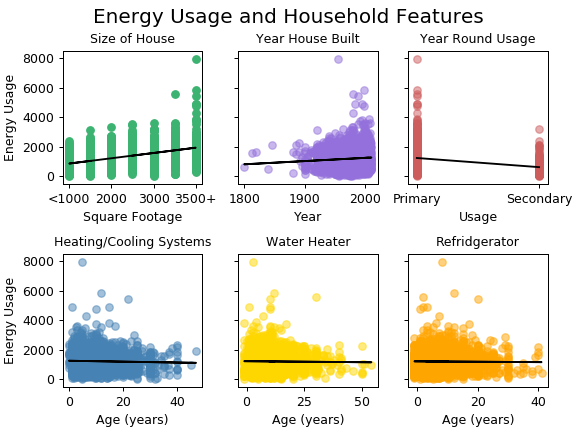

In [20]:
# Create a six panel figure

# calculate regression line
x1 = energy_sqft.Q7
y1 = energy_sqft.SAMPLE_USAGE

x2 = energy_yearbuilt.yearbuilt
y2 = energy_yearbuilt.SAMPLE_USAGE

x3 = energy_yearround.Q12
y3 = energy_yearround.SAMPLE_USAGE

x4 = energy_unitage.unitage
y4 = energy_unitage.SAMPLE_USAGE

x5 = energy_waterheater.Q26_001
y5 = energy_waterheater.SAMPLE_USAGE

x6 = energy_fridgeage.Q40_001_UNIT1
y6 = energy_fridgeage.SAMPLE_USAGE

stats1 = linregress(x1, y1)
m1 = stats1.slope
b1 = stats1.intercept

stats2 = linregress(x2, y2)
m2 = stats2.slope
b2 = stats2.intercept

stats3 = linregress(x3, y3)
m3 = stats3.slope
b3 = stats3.intercept

stats4 = linregress(x4, y4)
m4 = stats4.slope
b4 = stats4.intercept

stats5 = linregress(x5, y5)
m5 = stats5.slope
b5 = stats5.intercept

stats6 = linregress(x6, y6)
m6 = stats6.slope
b6 = stats6.intercept

# Create panel for each household feature on 2 by 3 grid
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey='row', constrained_layout=True)

f.suptitle('Energy Usage and Household Features', fontsize=16)

ax1.scatter(energy_sqft["Q7"], energy_sqft["SAMPLE_USAGE"],color='mediumseagreen')
ax1.plot(x1, m1 * x1 + b1, color="black")
ax1.set_title('Size of House', fontsize=10)
ax1.set_xticks((2,4,6,8))
ax1.set_xticklabels(('<1000','2000','3000','3500+'))
ax1.set_xlabel('Square Footage')
ax1.set_ylabel('Energy Usage')

ax2.scatter(energy_yearbuilt["yearbuilt"], energy_yearbuilt["SAMPLE_USAGE"],color='mediumpurple',alpha=0.5)
ax2.plot(x2, m2 * x2 + b2, color="black")
ax2.set_title('Year House Built', fontsize=10)
ax2.set_xlabel('Year')

ax3.scatter(energy_yearround["Q12"], energy_yearround["SAMPLE_USAGE"], color='indianred',alpha=0.5)
ax3.plot(x3, m3 * x3 + b3, color="black")
ax3.set_title('Year Round Usage', fontsize=10)
ax3.set_xticks((1,2))
ax3.set_xticklabels(('Primary','Secondary'))
ax3.set_xlabel('Usage')

ax4.scatter(energy_unitage["unitage"], energy_unitage["SAMPLE_USAGE"], color='steelblue',alpha=0.5)
ax4.plot(x4, m4 * x4 + b4, color="black")
ax4.set_title('Heating/Cooling Systems', fontsize=10)
ax4.set_xlabel('Age (years)')
ax4.set_ylabel('Energy Usage')

ax5.scatter(energy_waterheater["Q26_001"], energy_waterheater["SAMPLE_USAGE"], color='gold',alpha=0.5)
ax5.plot(x5, m5 * x5 + b5, color="black")
ax5.set_title('Water Heater', fontsize=10)
ax5.set_xlabel('Age (years)')

ax6.scatter(energy_fridgeage["Q40_001_UNIT1"], energy_fridgeage["SAMPLE_USAGE"], color='orange',alpha=0.5)
ax6.plot(x6, m6 * x6 + b6, color="black")
ax6.set_title('Refridgerator', fontsize=10)
ax6.set_xlabel('Age (years)')

plt.savefig("Householdfeatures.png")

## Figure 3 - Weather

In [78]:
# Import historic weather data from NOAA
file4 = "Data/noaa2010.csv"
noaa_df = pd.read_csv(file4)

# Subset to important columns - there are too many!
noaa_df_subset=noaa_df[["STATION","NAME","LATITUDE","LONGITUDE","ANN-TAVG-NORMAL","ANN-TMAX-AVGNDS-GRTH090",
                        "ANN-TMIN-AVGNDS-LSTH020"]]

In [80]:
# Incorporated citipy to determine city based on latitude and longitude for each weather station
!pip install citipy
from citipy import citipy

noaa_df["Lat"]=noaa_df["LATITUDE"].astype(float)
noaa_df["Lon"]=noaa_df["LONGITUDE"].astype(float)


lat_lngs = noaa_df[["Lat","Lon","ANN-TAVG-NORMAL"]]

for index, row in lat_lngs.iterrows():
    
    lat = row['Lat']
    
    lon = row['Lon']
    
    city = citipy.nearest_city(lat, lon).city_name
    
    # If the city is unique, then add it to a our cities list
    lat_lngs.loc[index, 'city'] = city

In [81]:
# Incorporated citipy to determine city based on latitude and longitude for each household
lat_lngs2 = merged_df[["Latitude","Longitude","SAMPLE_USAGE"]]

for index, row in lat_lngs2.iterrows():
    
    lat = row['Latitude']
    
    lon = row['Longitude']
    
    city = citipy.nearest_city(lat, lon).city_name
    
    # If the city is unique, then add it to a our cities list
    lat_lngs2.loc[index, 'city'] = city

In [85]:
# Calculate the average temperature for each city - there can be more than one station per city
bycity = lat_lngs.groupby("city")
bycity_tempaverage = bycity["ANN-TAVG-NORMAL"].mean()

# Calculate the average energy usage for each city - there can be more than one household per city
bycity2 = lat_lngs2.groupby("city")
bycity_energyaverage = bycity2["SAMPLE_USAGE"].mean()

# Merge the results together, will lose records because there is not a weather station in every city
merged_weather = pd.merge(bycity_tempaverage, bycity_energyaverage, how='inner', on='city')

<IPython.core.display.Javascript object>


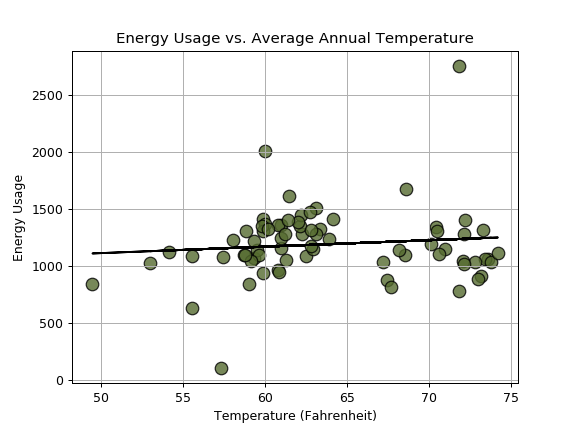

In [92]:
# Plot Figure 3
plt.figure(3)

# Calculate Regression Line
x = merged_weather['ANN-TAVG-NORMAL']
y = merged_weather.SAMPLE_USAGE

stats = linregress(x, y)
m = stats.slope
b = stats.intercept

# Draw Scatter Plot and Regression Line
plt.scatter(merged_weather['ANN-TAVG-NORMAL'], merged_weather['SAMPLE_USAGE'], marker="o", 
            facecolors="darkolivegreen", s=100, edgecolors="black", alpha=0.8)
plt.plot(x, m * x + b, color="black")

# Add title and axis labels
plt.title("Energy Usage vs. Average Annual Temperature")
plt.xlabel("Temperature (Fahrenheit)")
plt.ylabel("Energy Usage")

# Overlay grid
plt.grid()

# Save figure
plt.savefig("Weather.png")

# Display
plt.show()

## Figure 4 - Attitude, Income, Energy Usage

In [95]:
file5 = "Data/attitudes_clean4.csv"
attitudes_df = pd.read_csv(file5)

<IPython.core.display.Javascript object>


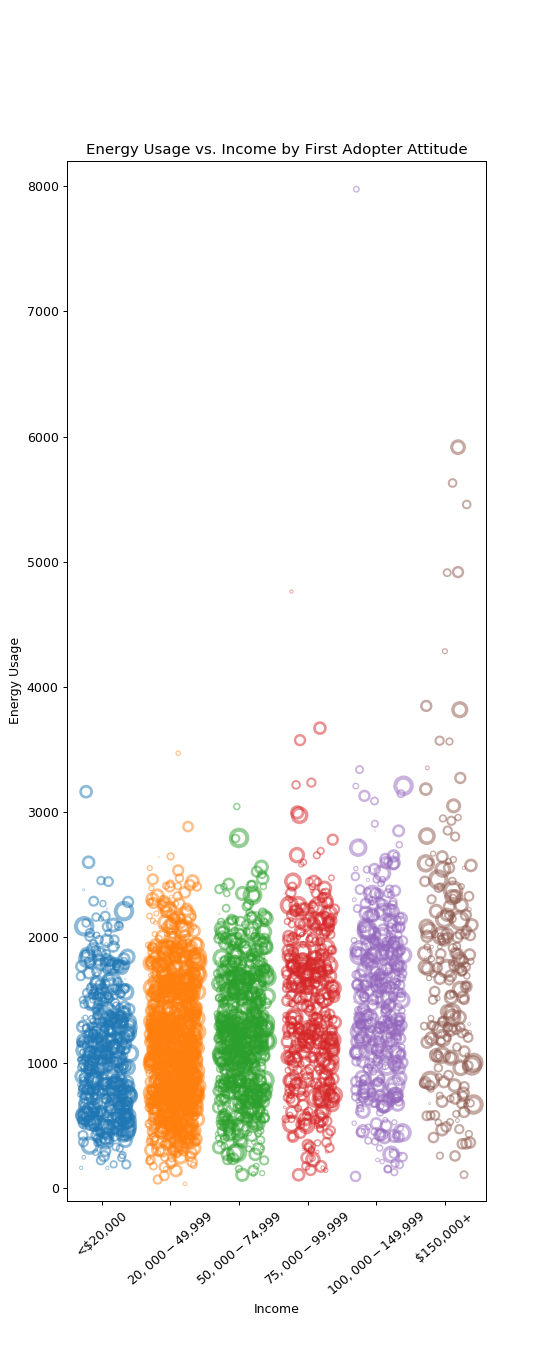

In [105]:
# Plot Figure 4
fig, ax10 = plt.subplots(1,1)
sns.stripplot(attitudes_df["income"],attitudes_df["SAMPLE_USAGE"],s=attitudes_df["firstadopter"]*2.5,
              marker="$\circ$",edgecolor="black",alpha=0.5,jitter=.35)

# Control x and y limits
plt.ylim(-100,8200)
plt.xlim(-0.5,5.6)

# Add title and axis labels
plt.title("Energy Usage vs. Income by First Adopter Attitude")
plt.ylabel("Energy Usage")
plt.xlabel("Income")

# Place and rename ticks
ax10.set_xticks((0,1,2,3,4,5))
ax10.set_xticklabels(('<$20,000','$20,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$149,999','$150,000+'),rotation=40)

# Control size and save image
from pylab import rcParams
rcParams['figure.figsize'] = 6, 12
plt.savefig("BubbleFirstAdopter.png")

<IPython.core.display.Javascript object>


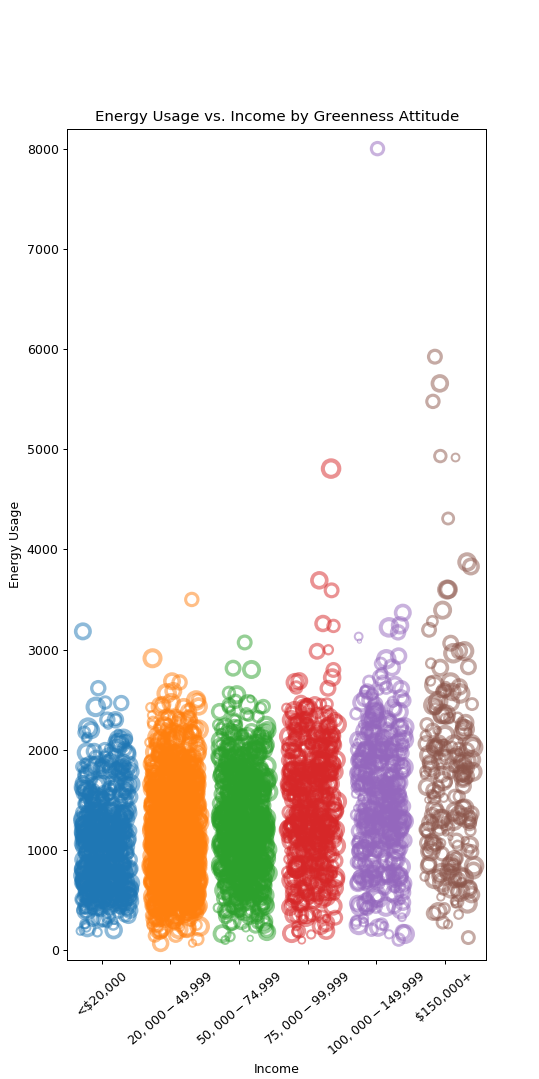

In [106]:
fig, ax10 = plt.subplots(1,1)
sns.stripplot(attitudes_df["income"],attitudes_df["SAMPLE_USAGE"],s=attitudes_df["greenness"]*2.5,
              marker="$\circ$",edgecolor="black",alpha=0.5,jitter=.35)

# Control x and y limits
plt.ylim(-100,8200)
plt.xlim(-0.5,5.6)

# Add title and axis labels
plt.title("Energy Usage vs. Income by Greenness Attitude")
plt.ylabel("Energy Usage")
plt.xlabel("Income")

# Place and rename ticks
ax10.set_xticks((0,1,2,3,4,5))
ax10.set_xticklabels(('<$20,000','$20,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$149,999','$150,000+'),rotation=40)

# Control size and save image
from pylab import rcParams
rcParams['figure.figsize'] = 6, 12
plt.savefig("BubbleGreeness.png")

<IPython.core.display.Javascript object>


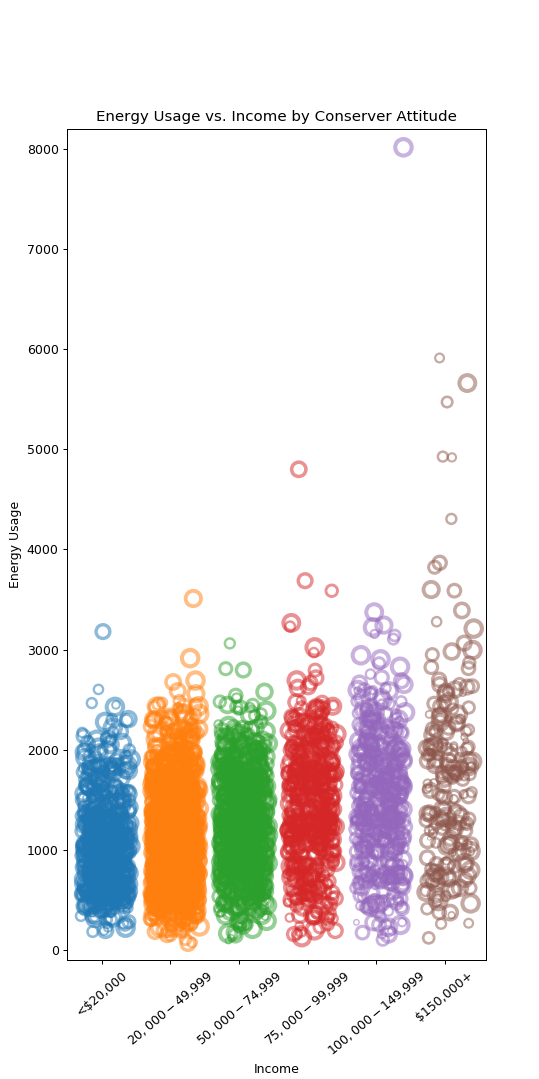

In [107]:
fig, ax10 = plt.subplots(1,1)
sns.stripplot(attitudes_df["income"],attitudes_df["SAMPLE_USAGE"],s=attitudes_df["conserver"]*2.5,
              marker="$\circ$",edgecolor="black",alpha=0.5,jitter=.35)

# Control x and y limits
plt.ylim(-100,8200)
plt.xlim(-0.5,5.6)

# Add title and axis labels
plt.title("Energy Usage vs. Income by Conserver Attitude")
plt.ylabel("Energy Usage")
plt.xlabel("Income")

# Place and rename ticks
ax10.set_xticks((0,1,2,3,4,5))
ax10.set_xticklabels(('<$20,000','$20,000-$49,999','$50,000-$74,999','$75,000-$99,999','$100,000-$149,999','$150,000+'),rotation=40)

# Control size and save image
from pylab import rcParams
rcParams['figure.figsize'] = 6, 12
plt.savefig("BubbleConserver.png")